# Solving Elliptic equation



## Computing the $H^{-s}$ with piecewise linear tent functions

We will compute 
$$
||f||_{H^{-1}}^2 \approx [f, \psi]\Theta^{-1}[f, \psi]
$$

where 
\begin{align}
 &[f, \psi] = (\int f \psi_1, \dots, \int f \psi_N) \\
 &\Theta_{ij} = \int \psi_i (-\Delta \psi_j) = \int \nabla \psi_i \nabla \psi_j
\end{align}


We define tent functions

\begin{align}
\psi_i^{\varepsilon} = \varepsilon^{-1}\text{max}\{1- \frac{|x -c_i|}{\varepsilon},0  \}  = \begin{cases}\varepsilon^{-1}(1 + \frac{x- c_i}{\varepsilon}) \quad c_i - \varepsilon \leq x \leq c_i \\\varepsilon^{-1}(1 - \frac{x- c_i}{\varepsilon})  \quad c_i \leq x \leq c_i + \varepsilon\\0
 \end{cases}
\end{align}



Observe that 
\begin{align}
\int_{\Omega} \psi_0^1 = \int_{-1}^{0} 1 - x + \int_{0}^1 x-1 = 2\int_{0}^{1} x-1 = 1
\end{align}

And so 
$$
\int_{\Omega} \psi_{c}^\varepsilon = 1
$$
which makes it a an approximation of the identity.

Moreover 
\begin{align}
\nabla \psi_i^{\varepsilon} = \begin{cases}\varepsilon^{-2} \text{sign}(c_i -x) \quad x \in [c_i- \varepsilon, c_i+ \varepsilon] \\0 \end{cases}
\end{align}

Therefore 

\begin{align}
&\int \psi_i^\varepsilon \psi_j^\varepsilon = \begin{cases} \frac{2}{3\varepsilon} \quad &|c_i - c_j| =0  \\ \frac{2}{3\varepsilon} \quad &|c_i - c_j| =\varepsilon  \\
0\end{cases} \\
&\int \nabla \psi_i^\varepsilon \nabla \psi_j^\varepsilon = \begin{cases} \frac{2}{\varepsilon} \quad  &|c_i - c_j| = 0\\  -\frac{1}{\varepsilon}  \quad &|c_i - c_j| = \varepsilon \\ 0 &\end{cases}
\end{align}

In [29]:
import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy


from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

import time

C:\Users\Matthieu\AppData\Local\Temp\ipykernel_38472\3863555121.py:6: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [30]:
# Define the domain of the problem
L = 1.0
lower = 0.0
upper = L
x = jnp.linspace(0, 1, 10000)
boundary = jnp.array([[lower, upper]]).T


In [31]:
N_m = 500
centers = jnp.linspace(0, L, int(N_m))[1:-1]
N_tent = len(centers)
epsilon = centers[1] - centers[0]
epsilon

Array(0.00200401, dtype=float64)

In [32]:
stiffness_matrix = vmap_compute_energy_ip(epsilon, centers, centers)
L2_matrix = vmap_compute_l2_ip(epsilon, centers, centers)
L_stiff = scipy.linalg.cho_factor(stiffness_matrix + 1e-10*jnp.eye(N_tent))
#L = scipy.linalg.cholesky(L2_matrix, lower=True)
#stiffness_matrix, L2_matrix

# Solving semilinear elliptic

With the Gauss-Newton iteration, we need to solve 

\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[\mathcal{P}(u_n) +\mathcal{P}'(u_n)(v - u_n)  - f, \boldsymbol{\psi}]^\intercal \Theta^{-1} [\mathcal{P}(u_n) +\mathcal{P}'(u_n)(v - u_n), \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

The case we wish to address is 

\begin{align}
&\mathcal{P}(u) = Lu + \tau(u)\\
&\mathcal{P}'(u) = Lu + \tau'(u)
\end{align}

In which case the above problem is 
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[Lv + \tau'(u_n)v - ( f -\tau(u_n) + \tau'(u_n)u_n), \boldsymbol{\psi}]^\intercal \Theta^{-1} [Lv + \tau'(u_n)v - ( f -\tau(u_n) + \tau'(u_n)u_n), \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

Denote $r_n = f -\tau(u_n) + \tau'(u_n)u_n$. Then
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[Lv + \tau'(u_n)v - r_n, \boldsymbol{\psi}]^\intercal \Theta^{-1} [Lv + \tau'(u_n)v -r_n, \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}


<!-- The important special case is when 

\begin{align}
&\mathcal{P}(u) = -\nu \Delta u + u + \tau(u)\\
&\mathcal{P}'(u) = -\nu \Delta u + u + \tau'(u)
\end{align}

In which case the above problem is 
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[-\nu \Delta v + v + \tau'(u_n)v + (\tau(u_n) - \tau'(u_n)u_n)  - f, \boldsymbol{\psi}]^\intercal \Theta^{-1} [\mathcal{P}(u_n) +\mathcal{P}'(u_n)(v - u_n), \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align} -->

Therefore we need to be able to compute 

$$
L_y L_x K(x,y)
$$

We will define $L$ to be a diff operator taking $K$ and returning 

\begin{aligned}
&L_x K(x,y) \\
&L_y L_x K(x,y)
\end{aligned}

In this case:
$$
L_x = -\nu\Delta_x + b(x)I
$$
so 
$$
L_y L_x = (-\nu\Delta_y + b(y)I)(-\nu\Delta_x + b(x)I) = \nu^2\Delta_y \Delta_x  - \varepsilon b(x)\Delta_y - \varepsilon b(y)\Delta_x + b(x)b(y)I
$$


# Elliptic equation with coefficients

We will solve 

$$
-\nu\Delta u + b(x)u = \xi 
$$

where $b$ will be non-constant, but smooth.

$$
\xi = \sum_{i=1}^\infty \xi_i \chi_i
$$

If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
f =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2}\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big) + b(x)\sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$


Text(0.5, 1.0, 'b(x)')

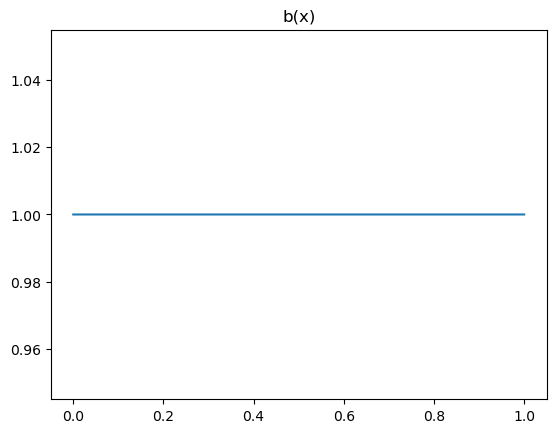

In [33]:
b = lambda x: jnp.ones_like(x)*1.0 #jnp.cos(4*jnp.pi*x)
b_values = b(x)
plt.plot(x, b_values)
plt.title("b(x)")

3.1


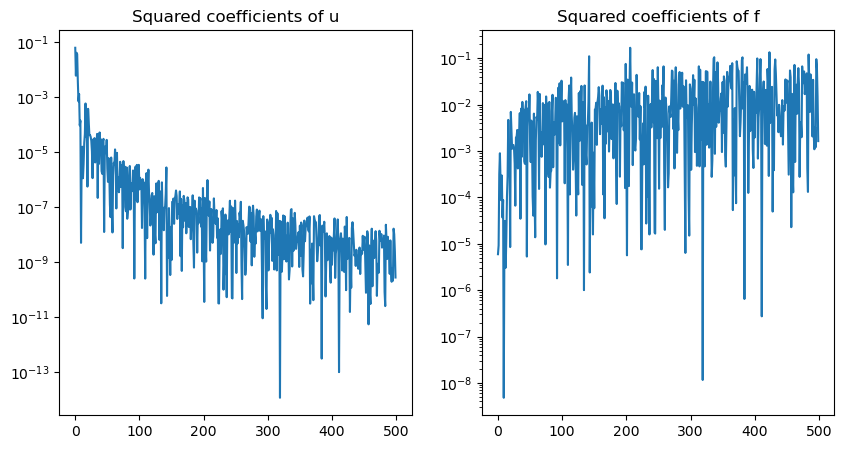

Text(0.5, 1.0, 'Function f')

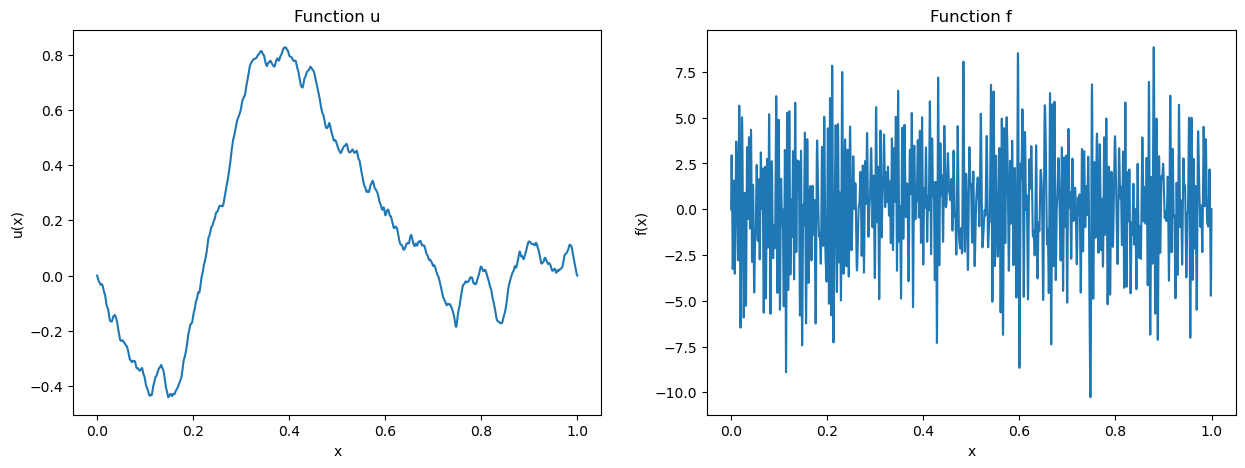

In [34]:
# Create the RHS

nu = 1e-3

# draw random values for the coefficients
#key = random.PRNGKey(54)
key = random.PRNGKey(11)

n_coef = 500

s = 1
alpha = 2*s+1 + 0.1
print(alpha)
decay_u = alpha/2
L = 1 # Lenght of the domain
coef_u =  jnp.ones(shape = (1, ))/(jnp.arange(1, n_coef+1)**(decay_u)) #jnp.ones(shape = (1, ))#random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))

coef_u = random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))
coef_f_constant = coef_u*(nu*jnp.arange(1, n_coef+1)**(2)*jnp.pi**2*L**2)

#x = jnp.linspace(0, L, 2000)
u_values = evaluate_function(x, coef_u, L=L)
f_values = evaluate_function(x, coef_f_constant, L=L) + b(x)*u_values

# Plot both the coeffients of u and f in 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(coef_u**2)
ax1.set_yscale('log')
ax1.set_title('Squared coefficients of u')
ax2.plot(coef_f_constant**2)
ax2.set_yscale('log')
ax2.set_title('Squared coefficients of f')

plt.show()

# Create 2 plots for the  function u and f
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, u_values)
ax[0].set_xlabel("x")
ax[0].set_ylabel("u(x)")
ax[0].set_title("Function u")

ax[1].plot(x, f_values)
ax[1].set_xlabel("x")
ax[1].set_ylabel("f(x)")
ax[1].set_title("Function f")

# Create measurements: integrate against test function

In [35]:
# Define the support of the test function 
support = jnp.array([centers - epsilon
                     , centers + epsilon]).T

from scipy.special import roots_legendre
n_order = 10
x_q, w_q = roots_legendre(n_order)
x_interval, w_interval = vmap_root_interval(x_q, w_q, support)

from utils_rough_pde import vmap_integrate_f_test_functions
# Create measurements of f 
root_psi, w_psi = vmap_root_interval(x_q, w_q, support)
psi_matrix = vmap_tent_vector(root_psi, epsilon, centers)
psi_matrix = psi_matrix * w_psi

In [36]:
# These are the roots for the rhs (it seems it's best to use the same roots for the rhs and the test functions)
n_order = 10
x_f, w_f = roots_legendre(n_order)
root_meas, w_meas = vmap_root_interval(x_f, w_f, support)

psi_matrix_meas = vmap_tent_vector(root_meas, epsilon, centers)
psi_matrix_meas = psi_matrix_meas * w_meas

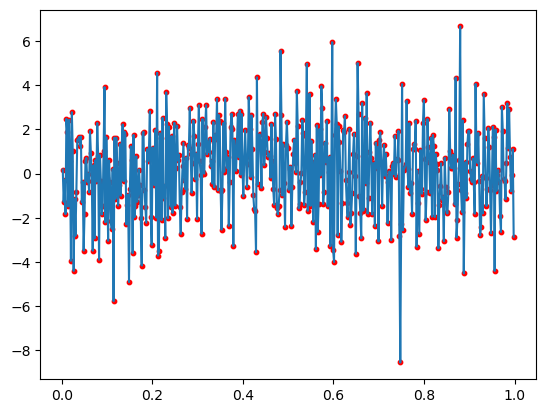

In [37]:
# Create the measurements of f
f_quad = evaluate_function(root_meas, coef_f_constant, L) + b(root_meas)*evaluate_function(root_meas, coef_u, L)
f_meas = vmap_integrate_f_test_functions(f_quad, psi_matrix_meas)

plt.plot(centers, f_meas)
plt.scatter(centers, f_meas, color='r', s = 10)

In [38]:
# Create the array of b values
root_b = b(root_psi)
bc = jnp.zeros(shape = (2, )) 

In [39]:
# To compute the errors
n_error = 100
x_error, w_error = roots_legendre(n_error)
x_error, w_error = root_interval(x_error, w_error, jnp.array([lower, upper]))
u_error = evaluate_function(x_error, coef_u, L)

# Solving the linear problem

In [40]:
from utils_optim import kernel_linear_solver

L2 error:  0.00394715932092219
L2 relative error:  0.010183449600996137


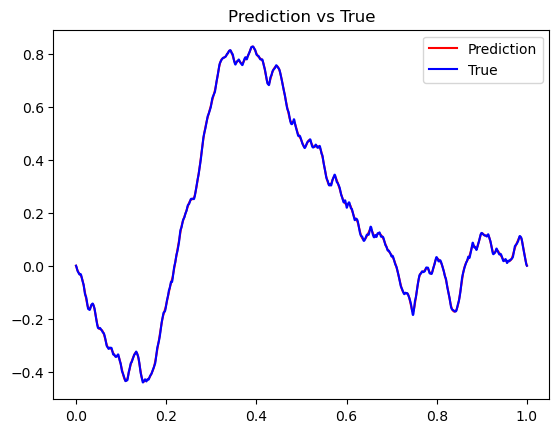

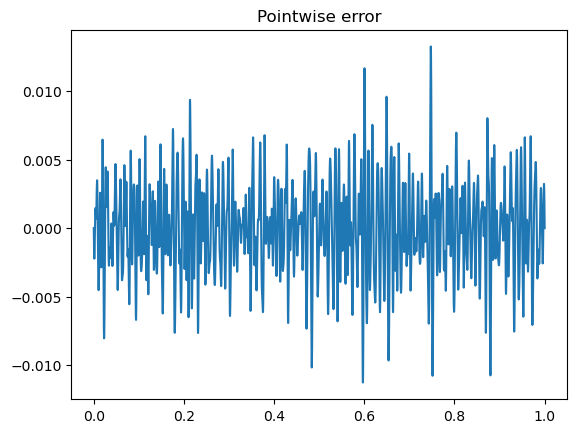

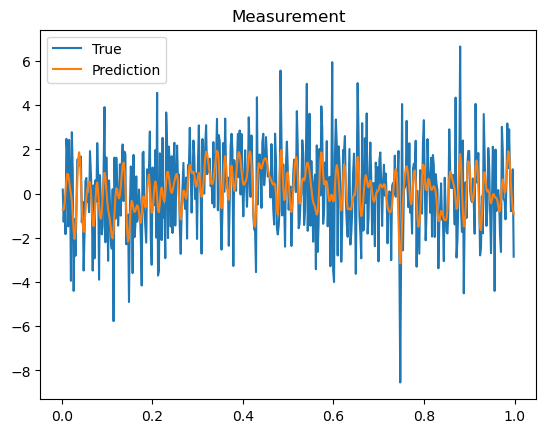

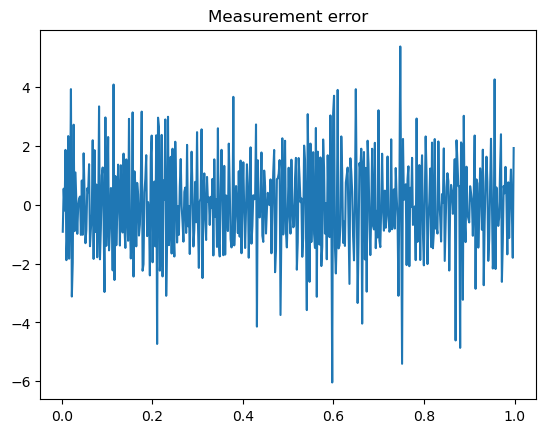

In [41]:
# Regularized linear solver
reg = 1e-8
length_scale = 0.1

solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, nu)
solver.solve_linear_prob(f_meas, reg, root_b, L_stiff)

l_2_error, l_2_rel, h_s_error, h_s_rel = solver.residuals
loss, relative_loss = solver.compute_error(x_error, w_error, u_error)

print("L2 error: ", loss)
print("L2 relative error: ", relative_loss)

pred = solver.evaluate_solution(x)

plt.plot(x, pred, color = "red", label = "Prediction")
plt.plot(x, u_values, color = "blue", label = "True")
plt.title("Prediction vs True")
plt.legend()

plt.figure()
plt.plot(x, pred - u_values, label = "Error")
plt.title("Pointwise error")
plt.show()

plt.figure()
plt.plot(centers, f_meas, label = "True")
plt.plot(centers, solver.meas, label = "Prediction")
plt.title("Measurement")
plt.legend()
plt.show()


plt.figure()
plt.plot(centers, solver.meas - f_meas)
plt.title("Measurement error")
plt.show()




## Unregularized version

L2 error:  0.0003653714697523185
L2 relative error:  0.0009426378935713516


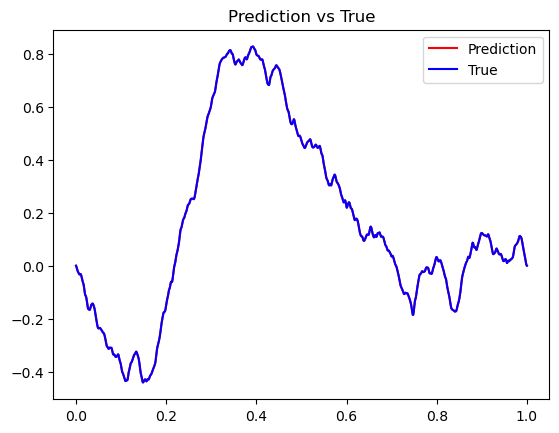

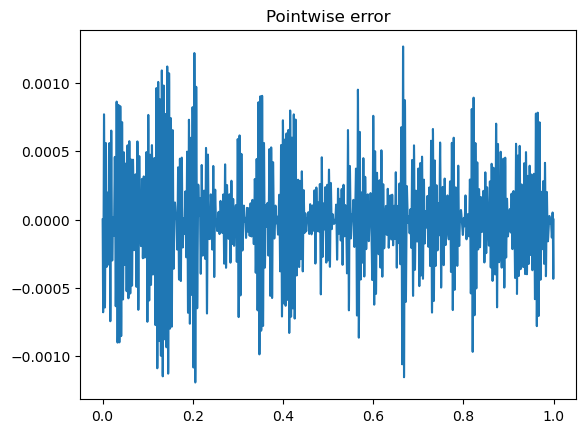

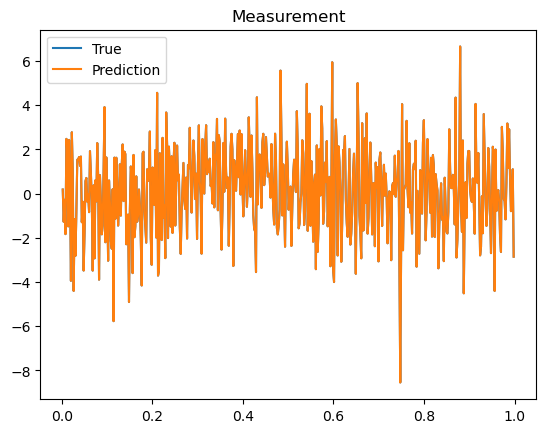

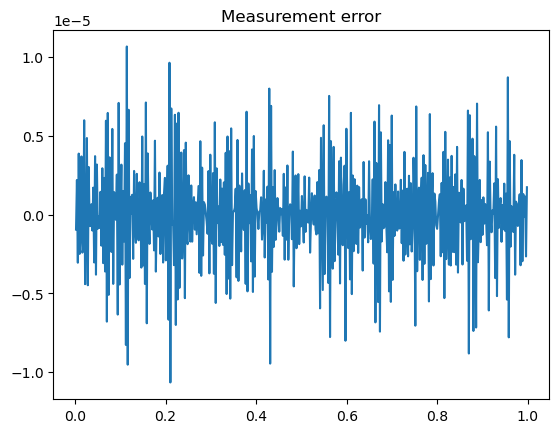

In [42]:
# With no regularization this time 
reg = None
length_scale = 0.1

solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, nu)
solver.solve_linear_prob(f_meas, reg, root_b, L_stiff)

l_2_error, l_2_rel, h_s_error, h_s_rel = solver.residuals
loss, relative_loss = solver.compute_error(x_error, w_error, u_error)

print("L2 error: ", loss)
print("L2 relative error: ", relative_loss)

pred = solver.evaluate_solution(x)

plt.plot(x, pred, color = "red", label = "Prediction")
plt.plot(x, u_values, color = "blue", label = "True")
plt.title("Prediction vs True")
plt.legend()

plt.figure()
plt.plot(x, pred - u_values, label = "Error")
plt.title("Pointwise error")
plt.show()

plt.figure()
plt.plot(centers, f_meas, label = "True")
plt.plot(centers, solver.meas, label = "Prediction")
plt.title("Measurement")
plt.legend()
plt.show()


plt.figure()
plt.plot(centers, solver.meas - f_meas)
plt.title("Measurement error")
plt.show()


# Semilinear elliptic PDE


With the Gauss-Newton iteration, we need to solve 

\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[\mathcal{P}(u_n) +\mathcal{P}'(u_n)(v - u_n)  - f, \boldsymbol{\psi}]^\intercal \Theta^{-1} [\mathcal{P}(u_n) +\mathcal{P}'(u_n)(v - u_n), \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

The case we wish to address is 

\begin{align}
&\mathcal{P}(u) = Lu + \tau(u)\\
&\mathcal{P}'(u) = Lu + \tau'(u)
\end{align}

In which case the above problem is 
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[Lv + \tau'(u_n)v - ( f -\tau(u_n) + \tau'(u_n)u_n), \boldsymbol{\psi}]^\intercal \Theta^{-1} [Lv + \tau'(u_n)v - ( f -\tau(u_n) + \tau'(u_n)u_n), \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

Denote $r_n = f -\tau(u_n) + \tau'(u_n)u_n$. Then
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[Lv + \tau'(u_n)v - r_n, \boldsymbol{\psi}]^\intercal \Theta^{-1} [Lv + \tau'(u_n)v -r_n, \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

Acutally we will have 
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,\Big([Lv + \tau'(u_n)v, \boldsymbol{\psi}] - \big([f, \psi] + [ \tau'(u_n)u_n - \tau(u_n), \psi] \big)\Big)^\intercal \Theta^{-1}\Big([Lv + \tau'(u_n)v, \boldsymbol{\psi}] - \big([f, \psi] + [ \tau'(u_n)u_n - \tau(u_n), \psi] \big)\Big) + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}


At each iteration, we need to 

1. Compute $r_n : = [f, \psi] + [ \tau'(u_n)u_n - \tau(u_n), \psi]$
2. Build the new operator/kernel matrix using $\tau'(u_n)$.
3. Solve the system.

\begin{aligned}
 -\nu \Delta u +u + u^3 &= \xi \quad x \in \Omega\\
u &= 0 \quad x \in \partial \Omega
\end{aligned}

We will iteratively solve
Let $r_n = \xi - \mathcal{P}(u_n)$
\begin{align}
    & \mathcal{P}'(u_n)u_{n+1} = \alpha r_n +  \mathcal{P}'(u_n)u_n \\
    &u_{n+1}(x_j) = g(x_j)
\end{align}
This yields the problem 
\begin{align}
    u_{n+1}  = \text{armin}_{v\in \mathcal{H}_K} & \,[\mathcal{P}'(u_n)v  - \big(\alpha r_n + \mathcal{P}'(u_n)u_n\big), \boldsymbol{\psi}]^2_{A^{-1}} + \gamma ||v||^2\\
    &\text{s.t. }v(x_j)  = g(x_j) \quad\text{for }j=1,\dots,M.
\end{align}

For calrity, we rewrite this as 

\begin{align}
    & \mathcal{P}'(u_n)u_{n+1} = \alpha ( \xi - Lu_n - \tau(u_n)) +  Lu_n + \tau'(u_n)u_n \\
    &u_{n+1}(x_j) = g(x_j)
\end{align}

In the case where $\alpha = 1$, we get 

\begin{align}
    & \mathcal{P}'(u_n)u_{n+1} = \xi - \tau(u_n) + \tau'(u_n)u_n \\
    &u_{n+1}(x_j) = g(x_j)
\end{align}

In [43]:
tau = lambda x : x**3
# We hardcode the derivative of tau (one could use autograd to compute it)
tau_prime = lambda x : 3*x**2
b = lambda x: jnp.ones_like(x)

3.1


Text(0.5, 1.0, 'Function f')

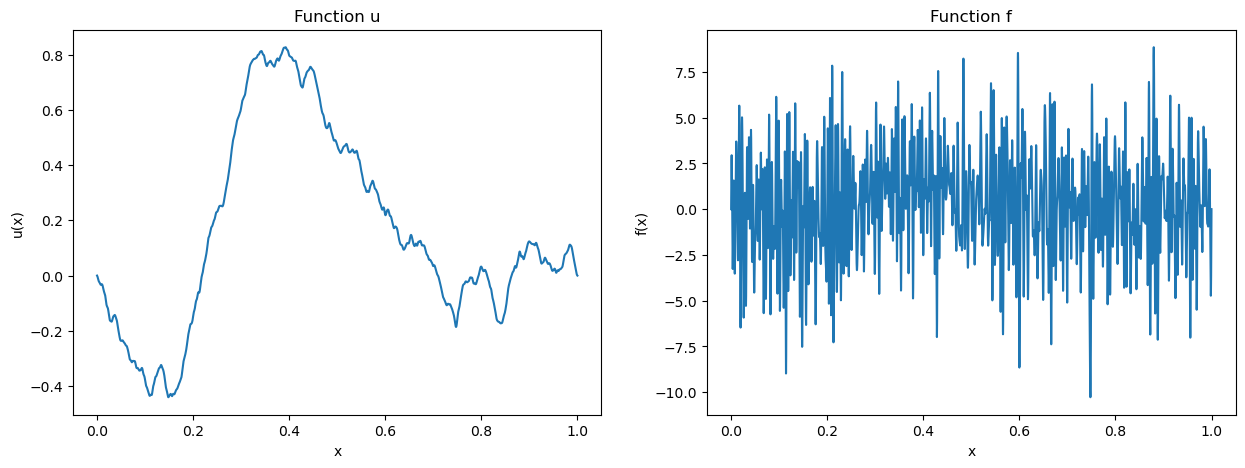

In [44]:
# Create the a semilinear elliptic PDE

nu = 1e-3
# draw random values for the coefficients
n_coef = 500

s = 1
alpha = 2*s+1 + 0.1
print(alpha)
decay_u = alpha/2
L = 1 # Lenght of the domain
coef_u =  jnp.ones(shape = (1, ))/(jnp.arange(1, n_coef+1)**(decay_u)) #jnp.ones(shape = (1, ))#random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))

coef_u = random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))
coef_f_linear = coef_u*(nu*jnp.arange(1, n_coef+1)**(2)*jnp.pi**2*L**2)

#x = jnp.linspace(0, L, 2000)
u_values = evaluate_function(x, coef_u, L=L)
f_values = evaluate_function(x, coef_f_linear, L=L) + b(x)*u_values + tau(u_values)
u_error = evaluate_function(x_error, coef_u, L)



# Create 2 plots for the  function u and f
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, u_values)
ax[0].set_xlabel("x")
ax[0].set_ylabel("u(x)")
ax[0].set_title("Function u")

ax[1].plot(x, f_values)
ax[1].set_xlabel("x")
ax[1].set_ylabel("f(x)")
ax[1].set_title("Function f")

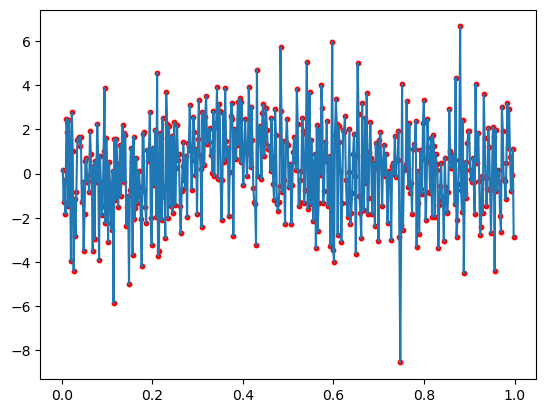

In [45]:
# Define the support of the test function 
support = jnp.array([centers - epsilon
                     , centers + epsilon]).T

from scipy.special import roots_legendre
n_order = 10
x_q, w_q = roots_legendre(n_order)
x_interval, w_interval = vmap_root_interval(x_q, w_q, support)

from utils_rough_pde import vmap_integrate_f_test_functions
# Create measurements of f 
root_psi, w_psi = vmap_root_interval(x_q, w_q, support)
psi_matrix = vmap_tent_vector(root_psi, epsilon, centers)
psi_matrix = psi_matrix * w_psi
# Create the measurements of f
f_quad = evaluate_function(root_psi, coef_f_linear, L) + b(root_psi)*evaluate_function(root_psi, coef_u, L) + tau(evaluate_function(root_psi, coef_u, L))
f_meas = vmap_integrate_f_test_functions(f_quad, psi_matrix)

plt.plot(centers, f_meas)
plt.scatter(centers, f_meas, color='r', s = 10)

In [46]:
# Create the array of b values
root_b = b(root_psi)

Residual relative L2 error:  1.0252448334420154
Residual relative Hs error:  2.046160156116873
L2 error:  0.16808643235469073
L2 relative error:  0.4336535653431209


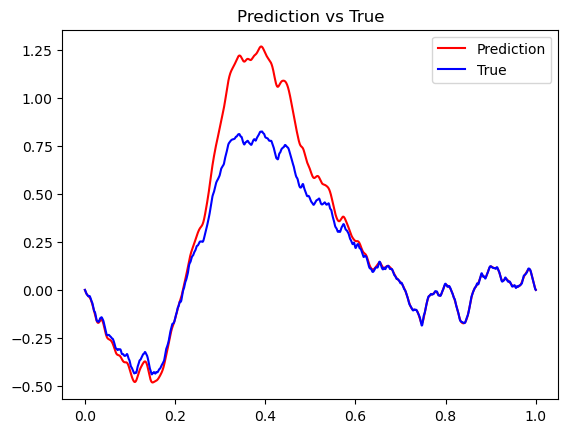

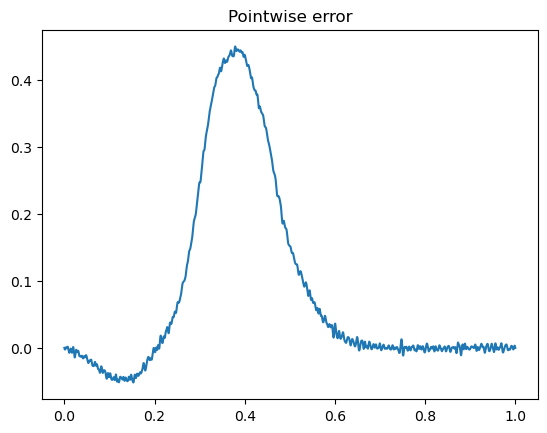

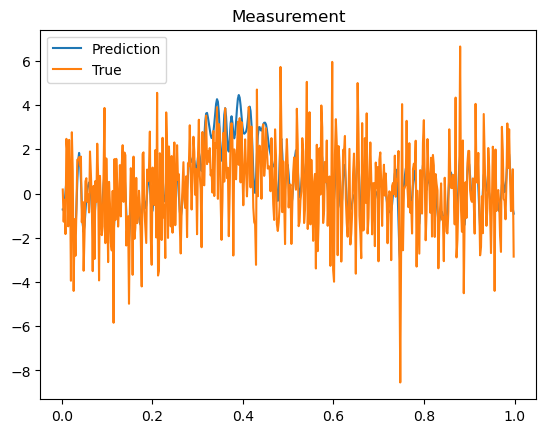

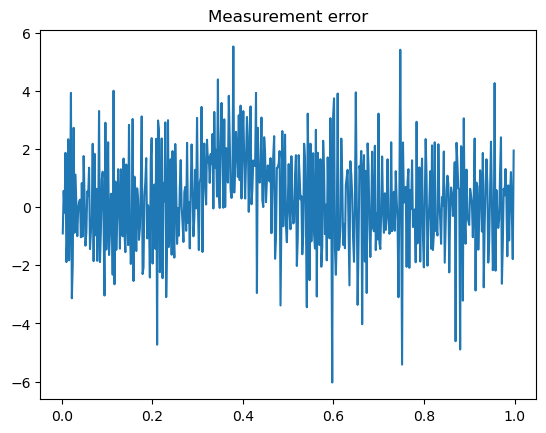

In [47]:
# First solve using the linear solver (for an initial guess)
reg = 1e-5
length_scale = 0.1


solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, nu)
solver.solve_linear_prob(f_meas, reg, root_b, L_stiff)

l_2_error, l_2_rel, h_s_error, h_s_rel = solver.compute_residuals_nl(f_meas, tau, root_b, L_stiff)
loss, relative_loss = solver.compute_error(x_error, w_error, u_error)

pred = solver.evaluate_solution(x)

print("Residual relative L2 error: ", l_2_rel)
print("Residual relative Hs error: ", h_s_rel)

print("L2 error: ", loss)
print("L2 relative error: ", relative_loss)

plt.plot(x, pred, color = "red", label = "Prediction")
plt.plot(x, u_values, color = "blue", label = "True")
plt.title("Prediction vs True")
plt.legend()

plt.figure()
plt.plot(x, pred - u_values, label = "Error")
plt.title("Pointwise error")
plt.show()

plt.figure()
plt.plot(centers,solver.non_linear_mes, label = "Prediction")
plt.plot(centers, f_meas, label = "True")
plt.title("Measurement")
plt.legend()
plt.show()


plt.figure()
plt.plot(centers,solver.non_linear_mes - f_meas)
plt.title("Measurement error")
plt.show()


In [48]:
from utils_optim import Gauss_Newton_solver_variable, Gauss_Newton_solver

In [49]:
length_scale = 0.05
linear_solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, nu)
reg = 1e-7

start = time.time()
solver_opt = Gauss_Newton_solver(L_stiff, f_meas, b, tau, tau_prime, psi_matrix, root_psi, linear_solver, reg, n_iter = 50)
end = time.time()
print("Time to compute the solution: ", end - start)

l_2_error, l_2_rel, h_s_error, h_s_rel = solver_opt.compute_residuals_nl(f_meas, tau, root_b, L_stiff)
loss, relative_loss = solver_opt.compute_error(x_error, w_error, u_error)

pred = solver_opt.evaluate_solution(x)

print("Residual relative L2 error: ", l_2_rel)
print("Residual relative Hs error: ", h_s_rel)

print("L2 error: ", loss)
print("L2 relative error: ", relative_loss)

Iteration 1, current error: 2.0454600000000003 H^-s, 0.69864 l_2. Improvement nan
Iteration 2, current error: 0.6072500000000001 H^-s, 0.36207 l_2. Improvement 0.7031200000000001
Iteration 3, current error: 0.32743000000000005 H^-s, 0.3261 l_2. Improvement 0.46080000000000004
Iteration 4, current error: 0.30916000000000005 H^-s, 0.32441000000000003 l_2. Improvement 0.055790000000000006
Iteration 5, current error: 0.30906 H^-s, 0.3244 l_2. Improvement 0.00032
Iteration 6, current error: 0.30906 H^-s, 0.3244 l_2. Improvement 0.0
Improvement too small, exiting
Time to compute the solution:  20.979111671447754
Residual relative L2 error:  0.32440398583506175
Residual relative Hs error:  0.30905842526225075
L2 error:  0.0008768770157784634
L2 relative error:  0.0022622935053874674


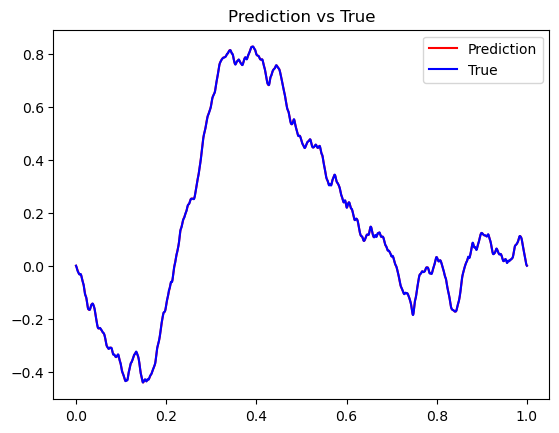

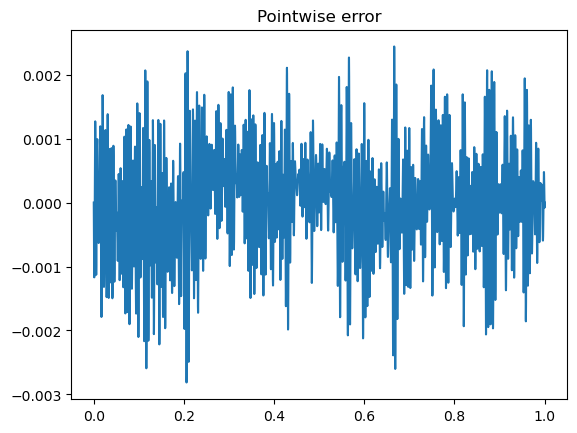

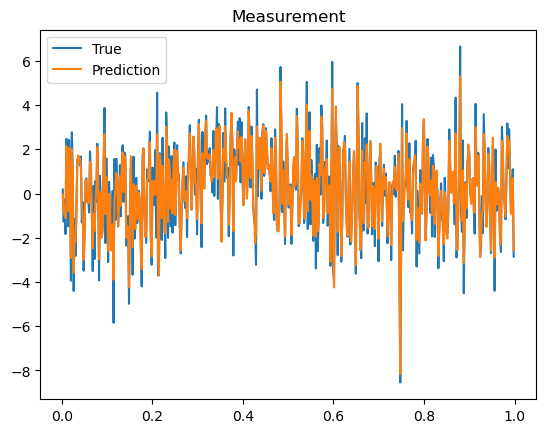

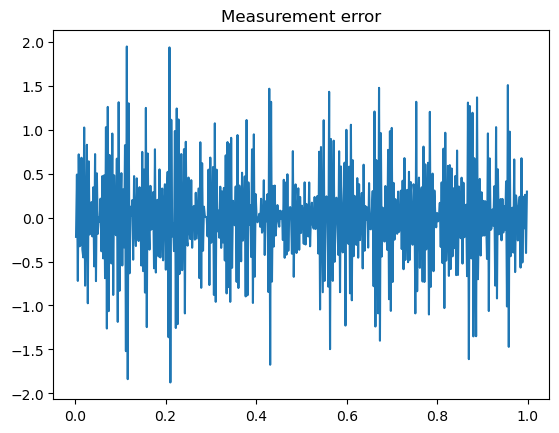

In [50]:
plt.plot(x, pred, color = "red", label = "Prediction")
plt.plot(x, u_values, color = "blue", label = "True")
plt.title("Prediction vs True")
plt.legend()

plt.figure()
plt.plot(x, pred - u_values, label = "Error")
plt.title("Pointwise error")
plt.show()

plt.figure()
plt.plot(centers, f_meas, label = "True")
plt.plot(centers,solver_opt.non_linear_mes, label = "Prediction")
plt.title("Measurement")
plt.legend()
plt.show()


plt.figure()
plt.plot(centers,solver_opt.non_linear_mes - f_meas)
plt.title("Measurement error")
plt.show()


## Unregularized version

In [51]:
length_scale = 0.05
linear_solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, nu)
reg = None


start = time.time()
solver_opt = Gauss_Newton_solver(L_stiff, f_meas, b, tau, tau_prime, psi_matrix, root_psi, linear_solver, reg, n_iter = 50)
end = time.time()
print("Time to compute the solution: ", end - start)

l_2_error, l_2_rel, h_s_error, h_s_rel = solver_opt.compute_residuals_nl(f_meas, tau, root_b, L_stiff)
loss, relative_loss = solver_opt.compute_error(x_error, w_error, u_error)

pred = solver_opt.evaluate_solution(x)

print("Residual relative L2 error: ", l_2_rel)
print("Residual relative Hs error: ", h_s_rel)

print("L2 error: ", loss)
print("L2 relative error: ", relative_loss)



Iteration 1, current error: 2.04545 H^-s, 0.62556 l_2. Improvement nan
Iteration 2, current error: 0.60663 H^-s, 0.18487 l_2. Improvement 0.70342
Iteration 3, current error: 0.32702000000000003 H^-s, 0.09727000000000001 l_2. Improvement 0.46092000000000005
Iteration 4, current error: 0.30893000000000004 H^-s, 0.09151000000000001 l_2. Improvement 0.055330000000000004
Iteration 5, current error: 0.30884 H^-s, 0.09148 l_2. Improvement 0.00028000000000000003
Increase in error, exiting
Time to compute the solution:  20.62536883354187
Residual relative L2 error:  0.09147956301183426
Residual relative Hs error:  0.30884294201370555
L2 error:  0.0006164851069320065
L2 relative error:  0.001590496989298132


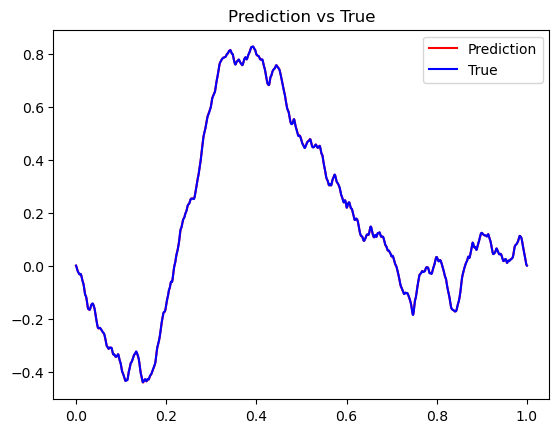

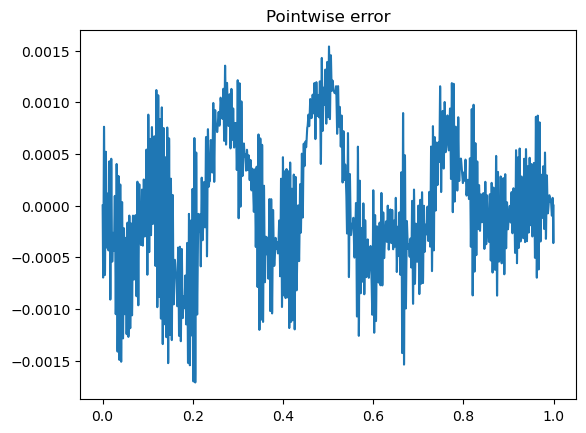

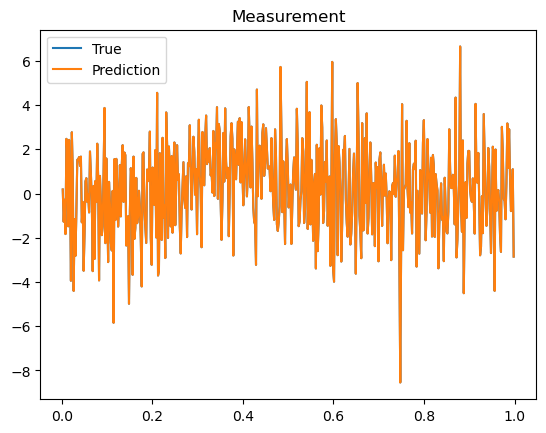

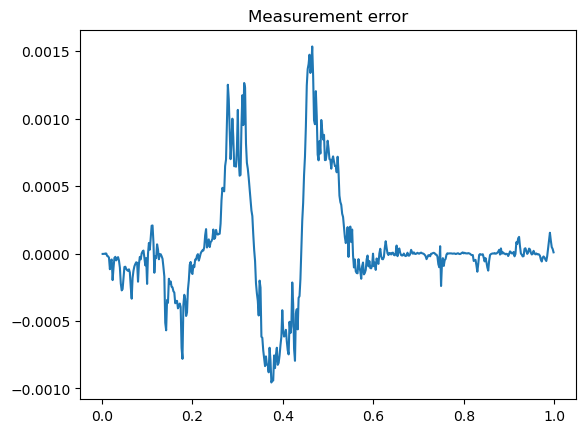

In [52]:
plt.plot(x, pred, color = "red", label = "Prediction")
plt.plot(x, u_values, color = "blue", label = "True")
plt.title("Prediction vs True")
plt.legend()

plt.figure()
plt.plot(x, pred - u_values, label = "Error")
plt.title("Pointwise error")
plt.show()

plt.figure()
plt.plot(centers, f_meas, label = "True")
plt.plot(centers,solver_opt.non_linear_mes, label = "Prediction")
plt.title("Measurement")
plt.legend()
plt.show()


plt.figure()
plt.plot(centers,solver_opt.non_linear_mes - f_meas)
plt.title("Measurement error")
plt.show()

# Sampling from white noise RHS

Let us solve 
\begin{aligned}
 -\nu \Delta u + u + u^3 &= \xi \quad x \in \Omega\\
u &= 0 \quad x \in \partial \Omega
\end{aligned}

where $\xi$ is a space white noise.

Observe that 

$$
[\xi, \psi] \sim \mathcal{N}(0, A)
$$

where 

$$
A_{ij} = \int \psi_i^\varepsilon \psi_j^\varepsilon
$$

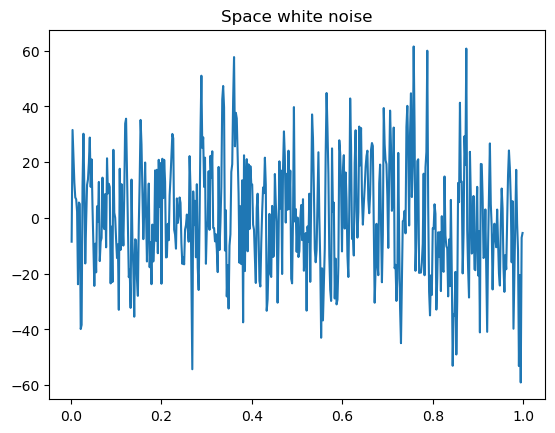

In [53]:
# # Draw measurements from a normal distribution
# key = random.PRNGKey(0)
# draw = random.multivariate_normal(key, mean = jnp.zeros(N_tent), cov = L2_matrix)

def sample_from_degenerate_gaussian(key, cov, size=1):
    # Perform SVD on the covariance matrix
    U, s, Vt = jnp.linalg.svd(cov)
    
    # Keep only the non-zero components (up to numerical stability)
    nonzero_indices = s > 1e-10  # Adjust this threshold as necessary
    s_nonzero = s[nonzero_indices]
    U_nonzero = U[:, nonzero_indices]
    
    # Sample from a lower-dimensional Gaussian
    lower_dim_samples = random.normal(key, shape = (len(s_nonzero), size))
    
    # Scale samples by the square root of the nonzero singular values
    scaled_samples = jnp.sqrt(s_nonzero)[:, jnp.newaxis] * lower_dim_samples
    
    # Transform the samples back to the original space
    samples =  U_nonzero @ scaled_samples
    
    return samples.T

key = random.PRNGKey(312)
f_meas = sample_from_degenerate_gaussian(key, L2_matrix, size=1)[0]
plt.plot(centers, f_meas)
plt.title("Space white noise")
plt.show()

In [54]:
length_scale = 0.01
linear_solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, nu)
reg = 1e-5


start = time.time()
solver_opt = Gauss_Newton_solver(L_stiff, f_meas, b, tau, tau_prime, psi_matrix, root_psi, linear_solver, reg, n_iter = 50)
end = time.time()
print("Time to compute the solution: ", end - start)

l_2_error, l_2_rel, h_s_error, h_s_rel = solver_opt.compute_residuals_nl(f_meas, tau, root_b, L_stiff)
loss, relative_loss = solver_opt.compute_error(x_error, w_error, u_error)

pred = solver_opt.evaluate_solution(x)
rhs_pred = solver_opt.non_linear_mes

print("Residual relative L2 error: ", l_2_rel)
print("Residual relative Hs error: ", h_s_rel)


Iteration 1, current error: 6.39085 H^-s, 2.22488 l_2. Improvement nan
Iteration 2, current error: 1.9440100000000002 H^-s, 0.66705 l_2. Improvement 0.69581
Iteration 3, current error: 0.9205200000000001 H^-s, 0.28096000000000004 l_2. Improvement 0.5264800000000001
Iteration 4, current error: 0.76692 H^-s, 0.21395000000000003 l_2. Improvement 0.16686
Iteration 5, current error: 0.75992 H^-s, 0.20932 l_2. Improvement 0.009130000000000001
Iteration 6, current error: 0.7596700000000001 H^-s, 0.20921 l_2. Improvement 0.00032
Iteration 7, current error: 0.7596600000000001 H^-s, 0.20920000000000002 l_2. Improvement 2e-05
Iteration 8, current error: 0.7596600000000001 H^-s, 0.20920000000000002 l_2. Improvement 0.0
Improvement too small, exiting
Time to compute the solution:  28.138129234313965
Residual relative L2 error:  0.20920463264753594
Residual relative Hs error:  0.7596606470262254


In [55]:
# Unregularized 

length_scale = 0.01
linear_solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, nu)
reg = None


start = time.time()
solver_opt = Gauss_Newton_solver(L_stiff, f_meas, b, tau, tau_prime, psi_matrix, root_psi, linear_solver, reg, n_iter = 50)
end = time.time()
print("Time to compute the solution: ", end - start)

l_2_error, l_2_rel, h_s_error, h_s_rel = solver_opt.compute_residuals_nl(f_meas, tau, root_b, L_stiff)
loss, relative_loss = solver_opt.compute_error(x_error, w_error, u_error)

pred_unreg = solver_opt.evaluate_solution(x)
rhs_pred_unreg = solver_opt.non_linear_mes

print("Residual relative L2 error: ", l_2_rel)
print("Residual relative Hs error: ", h_s_rel)




Iteration 1, current error: 6.39085 H^-s, 2.2248900000000003 l_2. Improvement nan
Iteration 2, current error: 1.9440100000000002 H^-s, 0.66705 l_2. Improvement 0.69581
Iteration 3, current error: 0.9205200000000001 H^-s, 0.28096000000000004 l_2. Improvement 0.5264800000000001
Iteration 4, current error: 0.76692 H^-s, 0.21395000000000003 l_2. Improvement 0.16686
Iteration 5, current error: 0.75992 H^-s, 0.20932 l_2. Improvement 0.009130000000000001
Iteration 6, current error: 0.7596700000000001 H^-s, 0.20921 l_2. Improvement 0.00032
Iteration 7, current error: 0.7596600000000001 H^-s, 0.20920000000000002 l_2. Improvement 2e-05
Iteration 8, current error: 0.7596600000000001 H^-s, 0.20920000000000002 l_2. Improvement 0.0
Improvement too small, exiting
Time to compute the solution:  27.77996802330017
Residual relative L2 error:  0.2092048467313893
Residual relative Hs error:  0.7596607660988689


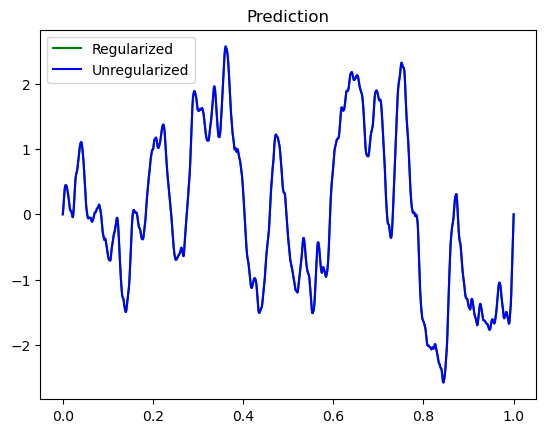

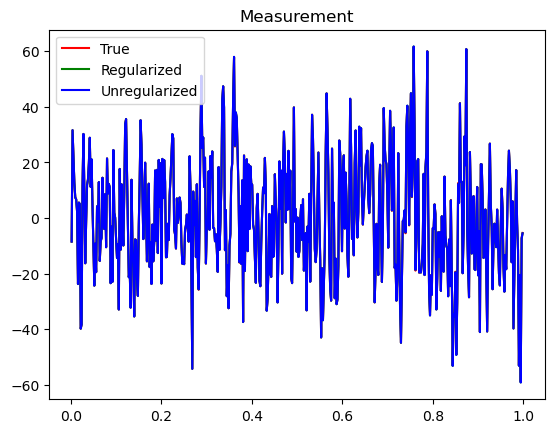

In [56]:
plt.plot(x, pred, color = "green", label = "Regularized")
plt.plot(x, pred_unreg, color = "blue", label = "Unregularized")
plt.title("Prediction")
plt.legend()


plt.figure()
plt.plot(centers, f_meas, label = "True", color = 'red')
plt.plot(centers,rhs_pred, label = "Regularized", color = 'green')
plt.plot(centers,rhs_pred_unreg, label = "Unregularized", color = 'blue')
plt.title("Measurement")
plt.legend()
plt.show()
